In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

TRADING_DAYS = 252

rf_annual = 0.03  # set your risk-free rate here (e.g., 0.025 = 2.5%)
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL"]
market = "SPY"



In [3]:
prices = yf.download(tickers + [market], period="5y", auto_adjust=True, progress=False)["Close"].dropna()
rets = np.log(prices).diff().dropna()

asset_rets = rets[tickers]
mkt_rets = rets[market]

mu = asset_rets.mean() * TRADING_DAYS
cov = asset_rets.cov() * TRADING_DAYS

mu, cov.head()


(Ticker
 AAPL     0.123799
 MSFT     0.149628
 NVDA     0.513533
 AMZN     0.067191
 GOOGL    0.248499
 dtype: float64,
 Ticker      AAPL      MSFT      NVDA      AMZN     GOOGL
 Ticker                                                  
 AAPL    0.076303  0.044434  0.074003  0.053951  0.049331
 MSFT    0.044434  0.065563  0.083292  0.058845  0.050617
 NVDA    0.074003  0.083292  0.267008  0.101523  0.084968
 AMZN    0.053951  0.058845  0.101523  0.123333  0.067172
 GOOGL   0.049331  0.050617  0.084968  0.067172  0.096023)

In [4]:
rf_daily = rf_annual / TRADING_DAYS
mkt_mu_annual = float(mkt_rets.mean() * TRADING_DAYS)

rows = []
for t in tickers:
    # Excess returns CAPM: (Ri - Rf) = alpha + beta*(Rm - Rf) + eps
    y = asset_rets[t] - rf_daily
    x = mkt_rets - rf_daily
    X = sm.add_constant(x.values)
    model = sm.OLS(y.values, X).fit()

    alpha_annual = model.params[0] * TRADING_DAYS
    beta = model.params[1]
    capm_er = rf_annual + beta * (mkt_mu_annual - rf_annual)

    rows.append({
        "ticker": t,
        "alpha_annual": alpha_annual,
        "beta": beta,
        "capm_expected_return_annual": capm_er
    })

capm_table = pd.DataFrame(rows).set_index("ticker").sort_values("beta", ascending=False)
capm_table


,alpha_annual,beta,capm_expected_return_annual
ticker,,,
NVDA,0.275294,2.128610,0.238239
AMZN,-0.107214,1.476104,0.174405
GOOGL,0.096718,1.244844,0.151781
AAPL,-0.026231,1.226939,0.150030
MSFT,0.008594,1.134981,0.141034


In [5]:
def port_ret(w, mu):
    return float(np.dot(w, mu))

def port_vol(w, cov):
    return float(np.sqrt(w @ cov @ w))

def min_var(cov):
    n = cov.shape[0]
    x0 = np.ones(n) / n
    bounds = [(0, 1)] * n
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    res = minimize(lambda w: port_vol(w, cov), x0=x0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x

def tangency(mu, cov, rf):
    n = len(mu)
    x0 = np.ones(n) / n
    bounds = [(0, 1)] * n
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    def neg_sharpe(w):
        v = port_vol(w, cov)
        if v <= 0:
            return 1e9
        return -((port_ret(w, mu) - rf) / v)
    res = minimize(neg_sharpe, x0=x0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x

def frontier(mu, cov, n_points=35):
    targets = np.linspace(mu.min(), mu.max(), n_points)
    vols = []
    w_list = []
    n = len(mu)
    bounds = [(0, 1)] * n

    for tr in targets:
        cons = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "eq", "fun": lambda w, tr=tr: np.dot(w, mu) - tr},
        ]
        x0 = np.ones(n) / n
        res = minimize(lambda w: port_vol(w, cov), x0=x0, method="SLSQP", bounds=bounds, constraints=cons)
        if not res.success:
            vols.append(np.nan)
            w_list.append(None)
        else:
            vols.append(port_vol(res.x, cov))
            w_list.append(res.x)

    return targets, np.array(vols), w_list

w_gmv = min_var(cov.values)
w_tan = tangency(mu.values, cov.values, rf_annual)

gmv_ret, gmv_vol = port_ret(w_gmv, mu.values), port_vol(w_gmv, cov.values)
tan_ret, tan_vol = port_ret(w_tan, mu.values), port_vol(w_tan, cov.values)

targets, vols, w_list = frontier(mu.values, cov.values, n_points=35)

gmv_ret, gmv_vol, tan_ret, tan_vol


(0.1537419216613183,
 0.23707426048042282,
 0.41230373449214747,
 0.39511759470129937)

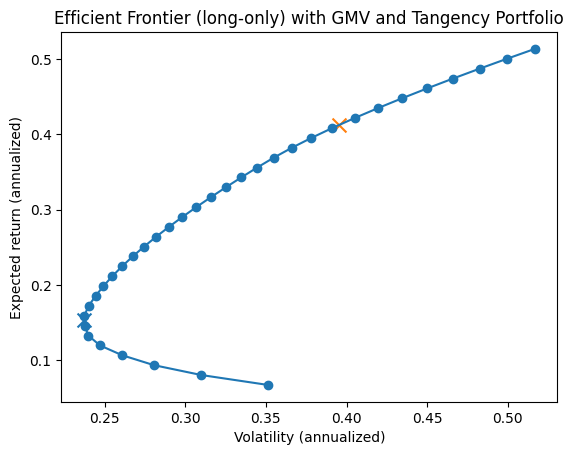

In [6]:
plt.figure()
plt.plot(vols, targets, marker="o", linestyle="-")
plt.scatter([gmv_vol], [gmv_ret], marker="x", s=100)
plt.scatter([tan_vol], [tan_ret], marker="x", s=100)
plt.xlabel("Volatility (annualized)")
plt.ylabel("Expected return (annualized)")
plt.title("Efficient Frontier (long-only) with GMV and Tangency Portfolio")
plt.savefig('efficient_frontier.png', dpi=300)
plt.show()


In [7]:
weights = pd.DataFrame({"GMV": w_gmv, "Tangency": w_tan}, index=tickers)
weights.sort_values("Tangency", ascending=False)


,GMV,Tangency
NVDA,0.000000e+00,6.180520e-01
GOOGL,1.327509e-01,3.819480e-01
MSFT,5.183693e-01,2.471981e-17
AAPL,3.488798e-01,0.000000e+00
AMZN,2.049142e-17,0.000000e+00
